In [1]:
from pyspark import SparkContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import udf
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, GradientBoostedTrees
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel


%matplotlib inline

In [2]:
hr_kaggle = sc.textFile('HR_comma_sep.csv')

In [10]:
hr_kaggle = hr_kaggle.map(lambda x: x.split(','))

In [11]:
hr_kaggle_final = hr_kaggle.map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]))

In [12]:
hr_kaggle_final.take(5)

[('satisfaction_level',
  'last_evaluation',
  'number_project',
  'average_montly_hours',
  'time_spend_company',
  'Work_accident',
  'left',
  'promotion_last_5years',
  'sales',
  'salary'),
 ('0.38', '0.53', '2', '157', '3', '0', '1', '0', 'sales', 'low'),
 ('0.8', '0.86', '5', '262', '6', '0', '1', '0', 'sales', 'medium'),
 ('0.11', '0.88', '7', '272', '4', '0', '1', '0', 'sales', 'medium'),
 ('0.72', '0.87', '5', '223', '5', '0', '1', '0', 'sales', 'low')]

In [13]:
hr_kaggle_final = hr_kaggle_final.toDF(['Satisfaction_Level', 'Last_Evaluation', 'no_of_projects', 'Average_hours', 'Time_Spent', 'Work_accident','left', 'Promotion', 'Dept', 'Salary'])

In [14]:
indexer = StringIndexer(inputCol="Dept", outputCol="dept")
indexed = indexer.fit(hr_kaggle_final).transform(hr_kaggle_final)

In [15]:
indexer1 = StringIndexer(inputCol="Salary", outputCol="salary")
indexed1 = indexer1.fit(indexed).transform(indexed)

In [16]:
indexed1.take(5)

[Row(Satisfaction_Level='satisfaction_level', Last_Evaluation='last_evaluation', no_of_projects='number_project', Average_hours='average_montly_hours', Time_Spent='time_spend_company', Work_accident='Work_accident', left='left', Promotion='promotion_last_5years', Dept='sales', Salary='salary', dept=0.0, salary=3.0),
 Row(Satisfaction_Level='0.38', Last_Evaluation='0.53', no_of_projects='2', Average_hours='157', Time_Spent='3', Work_accident='0', left='1', Promotion='0', Dept='sales', Salary='low', dept=0.0, salary=0.0),
 Row(Satisfaction_Level='0.8', Last_Evaluation='0.86', no_of_projects='5', Average_hours='262', Time_Spent='6', Work_accident='0', left='1', Promotion='0', Dept='sales', Salary='medium', dept=0.0, salary=1.0),
 Row(Satisfaction_Level='0.11', Last_Evaluation='0.88', no_of_projects='7', Average_hours='272', Time_Spent='4', Work_accident='0', left='1', Promotion='0', Dept='sales', Salary='medium', dept=0.0, salary=1.0),
 Row(Satisfaction_Level='0.72', Last_Evaluation='0.87

In [753]:
from pyspark.sql.types import *

# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 



In [754]:
columns = ['Satisfaction_Level', 'Last_Evaluation', 'no_of_projects', 'Average_hours', 'Time_Spent', 'Work_accident','left', 'Promotion', 'dept', 'salary']



In [756]:
#converted = convertColumn(indexed1, columns, FloatType())

In [17]:
hr_kaggle_final1 = indexed1.toPandas()

In [18]:
hr_kaggle_final_table = hr_kaggle_final1.drop(0)

In [19]:
hr_kaggle_final_table.head(5)

,Satisfaction_Level,Last_Evaluation,no_of_projects,Average_hours,Time_Spent,Work_accident,left,Promotion,Dept,Salary,dept,salary
1,0.38,0.53,2,157,3,0,1,0,sales,low,0.0,0.0
2,0.8,0.86,5,262,6,0,1,0,sales,medium,0.0,1.0
3,0.11,0.88,7,272,4,0,1,0,sales,medium,0.0,1.0
4,0.72,0.87,5,223,5,0,1,0,sales,low,0.0,0.0
5,0.37,0.52,2,159,3,0,1,0,sales,low,0.0,0.0


In [20]:
hr_kaggle_final_table = hr_kaggle_final_table.drop(['Dept', 'Salary'], 1)

In [21]:
hr_kaggle_final_table.head(5)

,Satisfaction_Level,Last_Evaluation,no_of_projects,Average_hours,Time_Spent,Work_accident,left,Promotion,dept,salary
1,0.38,0.53,2,157,3,0,1,0,0.0,0.0
2,0.8,0.86,5,262,6,0,1,0,0.0,1.0
3,0.11,0.88,7,272,4,0,1,0,0.0,1.0
4,0.72,0.87,5,223,5,0,1,0,0.0,0.0
5,0.37,0.52,2,159,3,0,1,0,0.0,0.0


In [22]:
hr_kaggle_final_table.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [23]:
hr_kaggle_final_table['Average_hours'] = hr_kaggle_final_table['Average_hours'].astype(int)

In [24]:
hr_kaggle_final_table['average_hours'] = pd.cut(hr_kaggle_final_table.Average_hours, bins=[80,100,120,140,160,180,200,220,240,260,280,300,320])

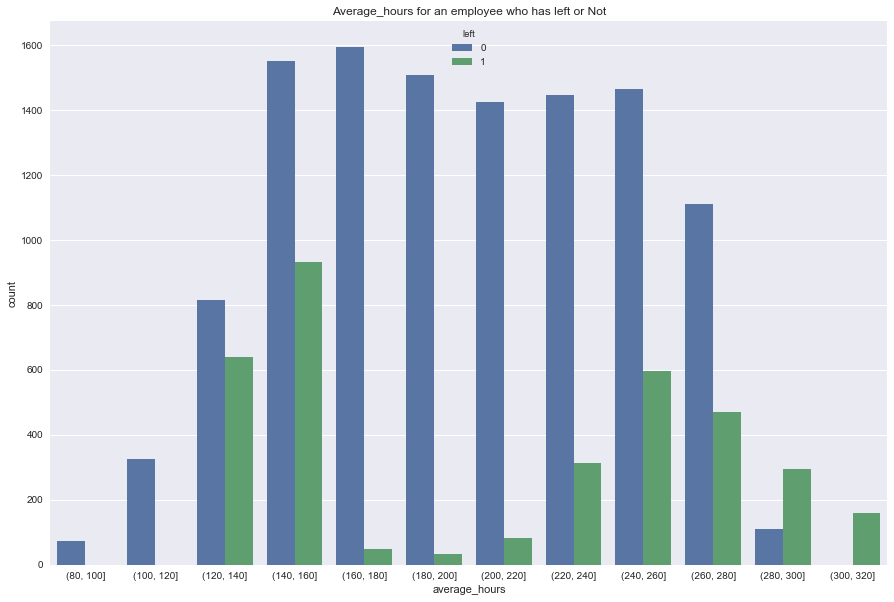

In [25]:
fig,ax= plt.subplots(figsize=(15,10));
sns.countplot(x='average_hours',data=hr_kaggle_final_table,hue='left');
plt.title('Average_hours for an employee who has left or Not');

In [26]:
hr_final_table = hr_kaggle_final_table.drop('Average_hours', 1)

In [27]:
hr_final_table.head(5)

,Satisfaction_Level,Last_Evaluation,no_of_projects,Time_Spent,Work_accident,left,Promotion,dept,salary,average_hours
1,0.38,0.53,2,3,0,1,0,0.0,0.0,"(140, 160]"
2,0.8,0.86,5,6,0,1,0,0.0,1.0,"(260, 280]"
3,0.11,0.88,7,4,0,1,0,0.0,1.0,"(260, 280]"
4,0.72,0.87,5,5,0,1,0,0.0,0.0,"(220, 240]"
5,0.37,0.52,2,3,0,1,0,0.0,0.0,"(140, 160]"


In [28]:
hr_final_table.Promotion.value_counts()

0    14680
1      319
Name: Promotion, dtype: int64

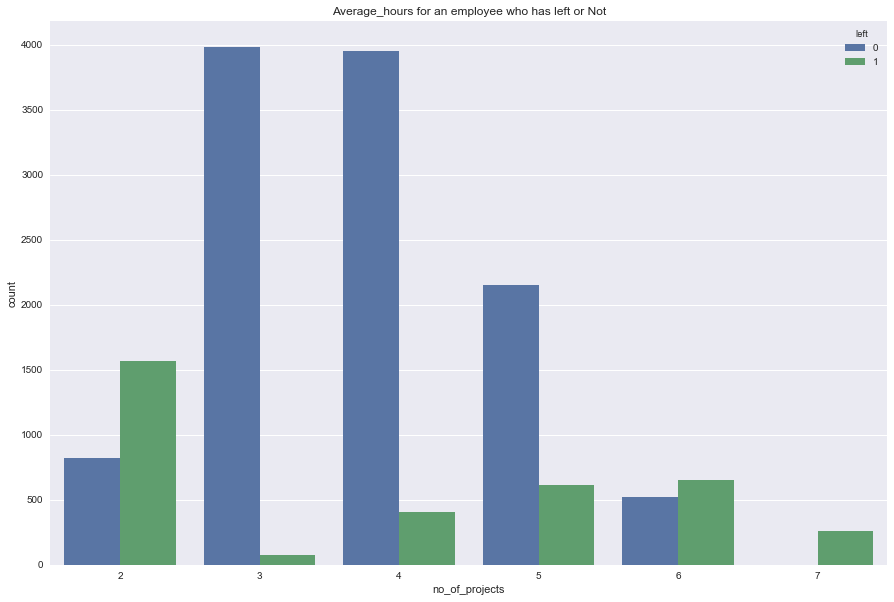

In [29]:
fig,ax= plt.subplots(figsize=(15,10));
sns.countplot(x='no_of_projects',data=hr_kaggle_final_table,hue='left');
plt.title('Average_hours for an employee who has left or Not');

In [30]:
hr_final_table.no_of_projects = hr_final_table.no_of_projects.astype(float)

In [31]:
hr_final_table.Time_Spent = hr_final_table.Time_Spent.astype(float)
hr_final_table.Work_accident = hr_final_table.Work_accident.astype(float)
hr_final_table.left = hr_final_table.left.astype(float)
hr_final_table.Promotion = hr_final_table.Promotion.astype(float)
hr_final_table.Satisfaction_Level = hr_final_table.Satisfaction_Level.astype(float)
hr_final_table.Last_Evaluation = hr_final_table.Last_Evaluation.astype(float)

In [32]:
label_encoder = LabelEncoder()

In [33]:
hr_final_table['average_hours'] = label_encoder.fit_transform(hr_final_table.average_hours)

In [35]:
#hr_final_table.average_hours = hr_final_table.average_hours.astype(DoubleType)

,Satisfaction_Level,Last_Evaluation,no_of_projects,Time_Spent,Work_accident,left,Promotion,dept,salary,average_hours
Satisfaction_Level,1.000000,0.105021,-0.142970,-0.100866,0.058697,-0.388375,0.025605,-0.008430,0.050022,-0.027774
Last_Evaluation,0.105021,1.000000,0.349333,0.131591,-0.007104,0.006567,-0.008684,0.004741,-0.013002,0.327923
no_of_projects,-0.142970,0.349333,1.000000,0.196786,-0.004741,0.023787,-0.006064,-0.008138,-0.001803,0.415709
Time_Spent,-0.100866,0.131591,0.196786,1.000000,0.002120,0.144822,0.067433,0.043883,0.048715,0.134406
Work_accident,0.058697,-0.007104,-0.004741,0.002120,1.000000,-0.154622,0.039245,0.003402,0.009247,-0.002670
left,-0.388375,0.006567,0.023787,0.144822,-0.154622,1.000000,-0.061788,-0.028394,-0.157898,0.054545
Promotion,0.025605,-0.008684,-0.006064,0.067433,0.039245,-0.061788,1.000000,0.072657,0.098119,-0.002524
dept,-0.008430,0.004741,-0.008138,0.043883,0.003402,-0.028394,0.072657,1.000000,0.102711,-0.009222
salary,0.050022,-0.013002,-0.001803,0.048715,0.009247,-0.157898,0.098119,0.102711,1.000000,-0.002232
average_hours,-0.027774,0.327923,0.415709,0.134406,-0.002670,0.054545,-0.002524,-0.009222,-0.002232,1.000000


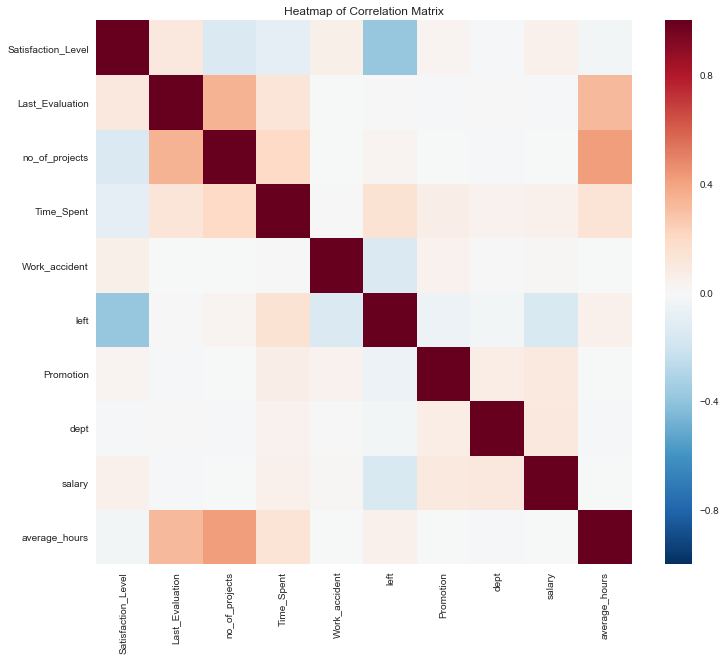

In [36]:
corr = hr_final_table.corr()
fig,ax= plt.subplots(figsize=(12,10));
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
sns.plt.title('Heatmap of Correlation Matrix')
corr

In [37]:
corr_left = pd.DataFrame(corr['left'].drop('left'))
corr_left.sort_values(by = 'left', ascending = False)

,left
Time_Spent,0.144822
average_hours,0.054545
no_of_projects,0.023787
Last_Evaluation,0.006567
dept,-0.028394
Promotion,-0.061788
Work_accident,-0.154622
salary,-0.157898
Satisfaction_Level,-0.388375


In [38]:
df1 = spark.createDataFrame(hr_final_table)

In [40]:
df1.show()

+------------------+---------------+--------------+----------+-------------+----+---------+----+------+-------------+
|Satisfaction_Level|Last_Evaluation|no_of_projects|Time_Spent|Work_accident|left|Promotion|dept|salary|average_hours|
+------------------+---------------+--------------+----------+-------------+----+---------+----+------+-------------+
|              0.38|           0.53|           2.0|       3.0|          0.0| 1.0|      0.0| 0.0|   0.0|            2|
|               0.8|           0.86|           5.0|       6.0|          0.0| 1.0|      0.0| 0.0|   1.0|            8|
|              0.11|           0.88|           7.0|       4.0|          0.0| 1.0|      0.0| 0.0|   1.0|            8|
|              0.72|           0.87|           5.0|       5.0|          0.0| 1.0|      0.0| 0.0|   0.0|            6|
|              0.37|           0.52|           2.0|       3.0|          0.0| 1.0|      0.0| 0.0|   0.0|            2|
|              0.41|            0.5|           2.0|     

In [41]:
def labeledData(data):
    #return data.map(lambda x: LabeledPoint(x[5], Vectors.dense(x[0],x[1],x[2],x[3],x[4],x[6],x[7],x[8],x[9])))
    return data.map(lambda x: LabeledPoint(x[5], Vectors.dense(x[0],x[1],x[2],x[3],x[6],x[7],x[8],x[9],x[4])))

In [42]:
#training_data, testing_data = labeledData(df.rdd).randomSplit([0.8, 0.2])
training_data,cv, testing_data = labeledData(df1.rdd).randomSplit([0.6,0.2, 0.2])

In [43]:
model_svm = SVMWithSGD.train(training_data)
model_bayes = NaiveBayes.train(training_data)

In [44]:
testPoint = testing_data.first()
print("testPoint", testPoint)

testPoint (1.0,[0.38,0.53,2.0,3.0,0.0,0.0,0.0,2.0,0.0])


In [46]:
testPoints = testing_data.collect()
for testPoint in testPoints:
    label = testPoint.label
    predictedLabel = model_svm.predict(testPoint.features)
    #print("label: %s , predicted: %s, correct: %s"  %(label,predictedLabel, label==predictedLabel))
    

In [47]:
def getMetrics(model, data):
    labels = data.map(lambda d: d.label)
    features = data.map(lambda d: d.features)
    predictions = model.predict(features)
    #predictionsAndLabels = predictions.ma
    predictionsAndLabels = data.map(lambda p: (p.label, float(model.predict(p.features))))
    return MulticlassMetrics(predictionsAndLabels)

In [48]:
metric = getMetrics(model_svm, testing_data)

In [49]:
metric.accuracy

0.7581806282722513

In [50]:
def buildDecisionTreeClassifier(trainData):
    
    model = DecisionTree.trainClassifier(trainData,numClasses=2, categoricalFeaturesInfo={}, impurity="gini", maxDepth=4, maxBins=100)

    return  model
%time m_tree =  buildDecisionTreeClassifier(training_data)


CPU times: user 12.5 ms, sys: 3.91 ms, total: 16.4 ms
Wall time: 1.8 s


In [51]:
def buildGBTClassifier(trainData):
    model_GBT = GradientBoostedTrees.trainClassifier(trainData, categoricalFeaturesInfo={})
    
    return model_GBT

%time m_GBT = buildGBTClassifier(training_data)


CPU times: user 244 ms, sys: 87.7 ms, total: 332 ms
Wall time: 37.1 s


In [990]:
#Caclusating the metrics using Spark Mulitclass
def getMetrics(model, data):
    labels = data.map(lambda d: d.label)
    features = data.map(lambda d: d.features)
    predictions = model.predict(features)
    predictionsAndLabels = predictions.zip(labels)
    return MulticlassMetrics(predictionsAndLabels)

In [991]:
metrics = getMetrics(m_tree, cv)


In [992]:
metrics.accuracy

0.9712606139777923

In [993]:
metrics.confusionMatrix()

DenseMatrix(2, 2, [2273.0, 46.0, 42.0, 701.0], 0)

In [994]:
metrics = getMetrics(m_GBT, cv)
metrics.accuracy


0.9751796211626388